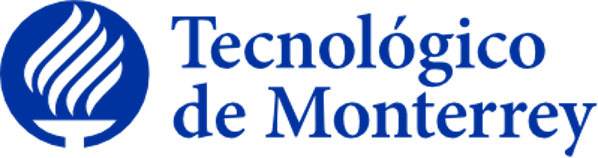

# **Maestría en Inteligencia Artificial Aplicada**

## **Proyecto Integrador - TC5035**

## Semana 6: Avance 4 - Modelos alternativos

### Profesores
- Dra. Grettel Barceló Alonso
- Dr. Luis Eduardo Falcón Morales

### Asesor
- Dr. Gerardo Jesús Camacho González

### Patrocinadores
- Dr. Jorge Antonio Ascencio Gutiérrez
- Yanmei King Loeza

### Equipo 29
- Carolina Lucas Dophe  –  A01702450
- Juan Pablo López Sánchez   –   A01313663
- Víctor Hugo Soto Herrera   –   A01706446

### Fecha de entrega
Domingo 22 de febrero de 2026

### Tabla de contenido
[Introducción](#intro)

1. [Carga de librerías y configuración inicial](#config)
2. [Preparación del entorno](#entorno)
3. [Definición del esquema de validación temporal](#esquema)
4. [Definición de métricas de evaluación](#metricas)
5. [Entrenamiento y evaluación de modelos](#modelos)
   1. [Naïve Estacional](#5_1)
   2. [ARIMA](#5_2)
   3. [SARIMAX](#5_3)
   4. [SVR](#5_4)
   5. [GPR](#5_5)
   6. [MLP](#5_6)
   7. [LSTM](#5_7)
6. [Comparación global de modelos](#comparacion)
7. [Selección de mejores modelos y ajuste de hiperparámetros](#seleccion)
8. [Análisis crítico](#analisis)

[Conclusiones](#conclusiones)

[Referencias](#ref)

### <a class="anchor" id="intro">Introducción</a>

En este avance se aborda la etapa de modelado predictivo del problema de estimación del volumen de producción agrícola mensual. Con el objetivo de identificar el enfoque más adecuado, se implementan y comparan múltiples modelos individuales, sin recurrir a técnicas de ensamble, pertenecientes a distintas familias metodológicas, incluyendo enfoques estadísticos clásicos de series de tiempo, métodos de aprendizaje supervisado y arquitecturas neuronales.

La comparación sistemática entre modelos permite evaluar no solo su precisión predictiva, sino también su estabilidad, capacidad de generalización y robustez frente a patrones estacionales y no lineales presentes en la serie.

#### Objetivo de esta entrega

En esta sección se:

- Construyen **seis modelos individuales** empleando algoritmos de naturaleza diversa.
- Implementa un **esquema de partición temporal (80/20)** que preserva el orden cronológico y evita fuga de información.
- Evalúan todos los modelos bajo un conjunto homogéneo de métricas: **MAE**, **RMSE**, **MAPE**, **R²** y **MASE**, garantizando comparabilidad.
- Analiza el desempeño en términos de precisión y posible sobreajuste.
- Realiza optimización de hiperparámetros sobre los dos modelos con mejor desempeño preliminar.
- Selecciona el **modelo individual final recomendado**, justificando la decisión con base en criterios cuantitativos y metodológicos.

### <a class="anchor" id="config">1. Carga de librerías y configuración inicial</a>

En esta sección se cargan las librerías necesarias para la implementación de los distintos modelos, el cálculo de métricas y la visualización de resultados. Asimismo, se establecen configuraciones iniciales orientadas a garantizar reproducibilidad y claridad en el análisis.

In [2]:
# Librerías base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Modelos clásicos de series de tiempo
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modelos de Machine Learning
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Escalamiento (necesario para SVR, MLP, KNN)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Modelo LSTM (Deep Learning)
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import LSTM, Dense
#from keras.callbacks import EarlyStopping

# Métricas de evaluación
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

In [3]:
# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Configuración general
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

warnings.filterwarnings('ignore')

In [4]:
# Definición de rutas base
DATA_DIR = Path("data")
PROCESSED_DATA_DIR = DATA_DIR / "processed"

### <a class="anchor" id="entorno">2. Preparación del entorno</a>

En esta sección se realiza la carga de los conjuntos de datos previamente generados en el Avance 2, los cuales contienen las variables explicativas (`X_final_mensual.csv`) y la variable objetivo (`y_mensual.csv`).

Se restablece la estructura temporal mediante la conversión de la columna `Fecha` al tipo `datetime` y su asignación como índice, garantizando así la preservación del orden cronológico necesario para el modelado de series de tiempo.

Asimismo, se verifica la consistencia estructural de los datos antes de proceder a la etapa de particionamiento y entrenamiento de modelos.

#### 2.1 Carga de datos procesados

En este apartado se importan los conjuntos previamente procesados, asegurando que ambas matrices (predictoras y variable objetivo) compartan el mismo índice temporal y se encuentren correctamente ordenadas.

La conversión explícita de la columna `Fecha` al formato `datetime` permite operar con criterios cronológicos estrictos, condición fundamental para evitar fuga de información en etapas posteriores.

In [5]:
# Cargar datos procesados
X = pd.read_csv(PROCESSED_DATA_DIR / "X_final_mensual.csv")
y = pd.read_csv(PROCESSED_DATA_DIR / "y_mensual.csv")

# Convertir Fecha a datetime
X['Fecha'] = pd.to_datetime(X['Fecha'])
y['Fecha'] = pd.to_datetime(y['Fecha'])

# Asignar Fecha como índice
X = X.set_index('Fecha')
y = y.set_index('Fecha')

# Ordenar por fecha
X = X.sort_index()
y = y.sort_index()

# Extraer la variable objetivo
y = y.iloc[:, 0]  # Volumenproduccion

print("Datos cargados exitosamente")
print(f"\nForma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

Datos cargados exitosamente

Forma de X: (345, 6)
Forma de y: (345,)


#### 2.2 Verificación estructural

Antes de proceder al modelado, se realiza una validación estructural de los datos con el fin de garantizar:

- La alineación exacta entre las observaciones de `X` y `y`.
- La correcta preservación del rango temporal.
- La ausencia de valores faltantes que puedan afectar el entrenamiento.
- La coherencia dimensional de las matrices.

Esta verificación es especialmente relevante en problemas de series de tiempo, donde desalineaciones o inconsistencias temporales pueden introducir errores metodológicos difíciles de detectar.

In [6]:
# Verificar alineación X-y
assert (X.index == y.index).all(), "Los índices de X e y no coinciden"

# Mostrar rango temporal
print(f"Rango temporal: {X.index.min()} a {X.index.max()}")
print(f"Número de observaciones: {len(X)}")
print(f"\nDimensiones:")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")

# Verificar valores faltantes
print(f"\nValores faltantes en X: {X.isnull().sum().sum()}")
print(f"Valores faltantes en y: {y.isnull().sum()}")

# Primeras y últimas filas
print(f"\nPrimeras observaciones:")
print(X.head(5))
print(f"\nÚltimas observaciones:")
print(X.tail(5))

Rango temporal: 1996-01-01 00:00:00 a 2024-12-01 00:00:00
Número de observaciones: 345

Dimensiones:
  X: (345, 6)
  y: (345,)

Valores faltantes en X: 0
Valores faltantes en y: 0

Primeras observaciones:
            Anio  Sembrada  Cosechada  Rendimiento   Mes_Sin   Mes_Cos
Fecha                                                                 
1996-01-01   0.0  0.170385   0.093448     0.828413  0.750000  0.933013
1996-02-01   0.0  0.170385   0.093448     0.828413  0.933013  0.750000
1996-03-01   0.0  0.170385   0.093448     0.828413  1.000000  0.500000
1996-04-01   0.0  0.170385   0.093448     0.828413  0.933013  0.250000
1996-05-01   0.0  0.170385   0.093448     0.828413  0.750000  0.066987

Últimas observaciones:
            Anio  Sembrada  Cosechada  Rendimiento   Mes_Sin   Mes_Cos
Fecha                                                                 
2024-08-01   1.0   0.55001    0.68664     0.100455  0.066987  0.250000
2024-09-01   1.0   0.55001    0.68664     0.100455  0.000000 

### <a class="anchor" id="esquema">3. Definición del esquema de validación temporal</a>

La evaluación de modelos en problemas de series de tiempo requiere un esquema de validación que respete estrictamente la estructura cronológica de los datos. A diferencia de problemas de regresión tradicionales, donde puede aplicarse particionamiento aleatorio o validación cruzada estándar, en contextos temporales el orden de las observaciones es parte fundamental de la información.

Por ello, se adopta un esquema de validación temporal con partición fija (hold-out), en el cual el modelo se entrena exclusivamente con datos históricos y se evalúa sobre un bloque futuro no observado durante el entrenamiento.

#### 3.1 Justificación metodológica

Para series de tiempo, utilizamos un enfoque de **validación temporal** (time-series split) en lugar de validación cruzada aleatoria, porque:

1. **Preserva el orden temporal**: Los datos futuros no pueden influir en el entrenamiento de datos pasados
2. **Evita fuga de información (data leakage)**: No se entrena con datos posteriores al período de prueba
3. **Refleja el escenario real**: En producción, siempre predecimos el futuro basado en el pasado
4. **Mantiene dependencias temporales**: Los patrones autoregresivos y estacionales se preservan

Se utiliza una partición **80/20** para maximizar los datos de entrenamiento mientras se mantiene un conjunto de prueba representativo.

#### 3.2 Split fijo (80/20)

Se implementa una partición cronológica donde el 80% inicial de las observaciones se destina al entrenamiento y el 20% final se reserva para evaluación.

Este enfoque permite:
- Maximizar la información histórica disponible para entrenamiento.
- Evaluar el desempeño en un período continuo y realista.
- Simular el escenario operativo en el cual se predicen valores futuros a partir de información pasada.

La división se realiza utilizando el índice temporal previamente establecido, garantizando que no exista superposición entre ambos conjuntos.

In [7]:
# Definir el punto de split (80% entrenamiento, 20% prueba)
split_idx = int(len(X) * 0.8)
train_date = X.index[split_idx]

# Crear subconjuntos
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Split realizado en: {train_date}")
print(f"\nConjunto de entrenamiento:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Período: {X_train.index.min()} a {X_train.index.max()}")

print(f"\nConjunto de prueba:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Período: {X_test.index.min()} a {X_test.index.max()}")

Split realizado en: 2019-01-01 00:00:00

Conjunto de entrenamiento:
  X_train: (276, 6)
  y_train: (276,)
  Período: 1996-01-01 00:00:00 a 2018-12-01 00:00:00

Conjunto de prueba:
  X_test: (69, 6)
  y_test: (69,)
  Período: 2019-01-01 00:00:00 a 2024-12-01 00:00:00


#### 3.3 Exportación de conjuntos de datos

Con el fin de mantener consistencia y trazabilidad entre avances, los subconjuntos de entrenamiento y prueba se exportan nuevamente al directorio `data/processed`.

Esta práctica permite:
- Reproducibilidad del experimento.
- Independencia entre notebooks.
- Facilitar comparaciones posteriores sin necesidad de recalcular el split.
- Asegurar que todos los integrantes del equipo puedan trabajar con exactamente las mismas particiones.

La exportación conserva el índice temporal (`Fecha`), lo cual es fundamental para modelos de series de tiempo y para la interpretación cronológica de los resultados.

In [8]:
# Exportar subconjuntos a data/processed
X_train.to_csv(PROCESSED_DATA_DIR / "X_train_temporal.csv")
X_test.to_csv(PROCESSED_DATA_DIR / "X_test_temporal.csv")
y_train.to_csv(PROCESSED_DATA_DIR / "y_train_temporal.csv", header=True, index=True)
y_test.to_csv(PROCESSED_DATA_DIR / "y_test_temporal.csv", header=True, index=True)

print("Subconjuntos exportados.")

Subconjuntos exportados.


### <a class="anchor" id="metricas">4. Definición de métricas de evaluación</a>

La selección de métricas de evaluación constituye un elemento central del proceso de modelado, ya que determina los criterios bajo los cuales se compararán los distintos enfoques.

En problemas de predicción de series de tiempo no existe una única métrica óptima; por ello, se adopta un conjunto complementario que permite evaluar:
- Precisión absoluta del error.
- Sensibilidad a desviaciones grandes.
- Error relativo en términos porcentuales.
- Capacidad explicativa global.
- Desempeño comparativo respecto a un modelo base.

Definir las métricas **antes del entrenamiento** evita sesgos en la selección del modelo y garantiza una comparación objetiva y consistente entre alternativas.

#### 4.1 Métricas utilizadas

Las siguientes métricas se definen **antes** de entrenar los modelos, para evitar sesgo en la selección:

1. **MAE (Mean Absolute Error)**
   - Fórmula: $\text{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$
   - Ventaja: Interpretable directamente en unidades originales
   - Uso: Evaluación práctica del error esperado

2. **RMSE (Root Mean Squared Error)**
   - Fórmula: $\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$
   - Ventaja: Penaliza errores grandes más severamente
   - Uso: Comparación entre modelos (sensible a outliers)

3. **MAPE (Mean Absolute Percentage Error)**
   - Fórmula: $\text{MAPE} = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_i - \hat{y}_i}{y_i}\right| \times 100$
   - Ventaja: Independiente de escala, útil en contexto productivo
   - Uso: Evaluación de precisión relativa

4. **R² (Coeficiente de determinación)**
   - Fórmula: $R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$
   - Ventaja: Métrica complementaria para evaluar capacidad explicativa
   - Uso: Proporción de varianza explicada

5. **MASE (Mean Absolute Scaled Error)**
   - Fórmula: $MASE = \frac{MAE_{modelo(TEST)}}{MAE_{naïve(TRAIN)}}$
   - El denominador se calcula exclusivamente sobre el conjunto de entrenamiento utilizando un modelo naïve estacional, garantizando que la evaluación en test no incorpore información futura.
   - Escala el error absoluto del modelo respecto al error de un modelo ingenuo de referencia.
   - Ventaja: Permite comparación justa entre modelos y evita problemas de escala.
   - Uso: Benchmarking contra un baseline temporal (naïve estacional en este caso).
   - Interpretación:
     - MASE < 1: Mejor que el baseline
     - MASE = 1: Igual al baseline
     - MASE > 1: Peor que el baseline

In [9]:
# Cálculo del denominador MASE
# Naïve estacional (lag=12 para mensual)
seasonality = 12

naive_train = y_train.shift(seasonality)
naive_train = naive_train.dropna()

mase_denom = mean_absolute_error(
    y_train[seasonality:], 
    naive_train
)

print(f"Denominador MASE (train naive estacional): {mase_denom:.4f}")

Denominador MASE (train naive estacional): 0.0866


In [10]:
# Función para calcular métricas de evaluación
def calculate_metrics(y_true, y_pred, mase_denom, model_name="Model"):
    """
    Calcula métricas de evaluación para un modelo.
    """

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Evitar división por cero en MAPE
    mape = np.mean(
        np.abs((y_true - y_pred) / np.where(y_true == 0, np.nan, y_true))
    ) * 100

    r2 = r2_score(y_true, y_pred)

    # MASE usando denominador pre-calculado
    mase = mae / mase_denom if mase_denom != 0 else np.inf

    return {
        'Modelo': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2,
        'MASE': mase
    }


# Lista para almacenar resultados de todos los modelos
resultados_modelos = []
modelos_entrenados = {} # Almacenar modelos para análisis posterior
print("Contenedor de resultados inicializado")

Contenedor de resultados inicializado


### <a class="anchor" id="modelos">5. Entrenamiento y evaluación de modelos</a>

En esta sección se implementan y evalúan los modelos seleccionados bajo un esquema metodológico uniforme que garantiza comparabilidad entre resultados.

Cada modelo sigue la siguiente estructura estándar:
1. **Descripción conceptual** del algoritmo y su pertinencia para series de tiempo.
2. **Entrenamiento** utilizando exclusivamente el conjunto `X_train`, `y_train`.
3. **Generación de predicciones** sobre el conjunto `X_test`.
4. **Cálculo de métricas de evaluación** previamente definidas.
5. **Visualización comparativa** entre valores reales y predichos.

> **Importante**: Los modelos se presentan en orden creciente de complejidad estructural y flexibilidad funcional, iniciando con enfoques estadísticos clásicos de series temporales y avanzando hacia métodos no lineales, probabilísticos y arquitecturas profundas, con el objetivo de analizar el valor incremental de cada familia metodológica.

#### <a class="anchor" id="5_1">5.1 Modelo de Referencia: Naïve Estacional</a>

**Descripción:** El modelo Naïve Estacional constituye el punto de referencia mínimo esperado para una serie temporal mensual con estacionalidad anual. La predicción para cada período del conjunto de prueba corresponde al valor observado en el mismo mes del año anterior (rezago de 12 meses).

Aunque no se trata de un modelo paramétrico formal, este enfoque captura la estructura estacional básica de la serie y establece un umbral de desempeño que **los modelos más complejos deben superar**. Además, sirve como referencia para la métrica MASE, cuyo valor es 1.0 por definición para este baseline.

In [11]:
# Modelo Naïve Estacional (referencia, lag = 12 meses)
# Predicción: valor del mismo mes del año anterior
lag_seasonal = 12

# Predicción usando shift sobre la serie completa
y_naive_full = y.shift(lag_seasonal)

# Extraer únicamente la parte correspondiente al test
y_naive = y_naive_full.loc[y_test.index].values

In [12]:
# Calcular métricas
metrics_naive = calculate_metrics(
    y_test,
    y_naive,
    mase_denom,
    model_name="Naïve Estacional"
)

print(metrics_naive)

# Almacenar para comparación
resultados_modelos.append(metrics_naive)

modelos_entrenados['Naive_Estacional'] = {
    'modelo': None,
    'y_pred': y_naive
}

{'Modelo': 'Naïve Estacional', 'MAE': 0.08938220801642596, 'RMSE': np.float64(0.11066893889876882), 'MAPE': np.float64(12.996778511639798), 'R²': -0.2500603650896023, 'MASE': 1.0321084369659865}


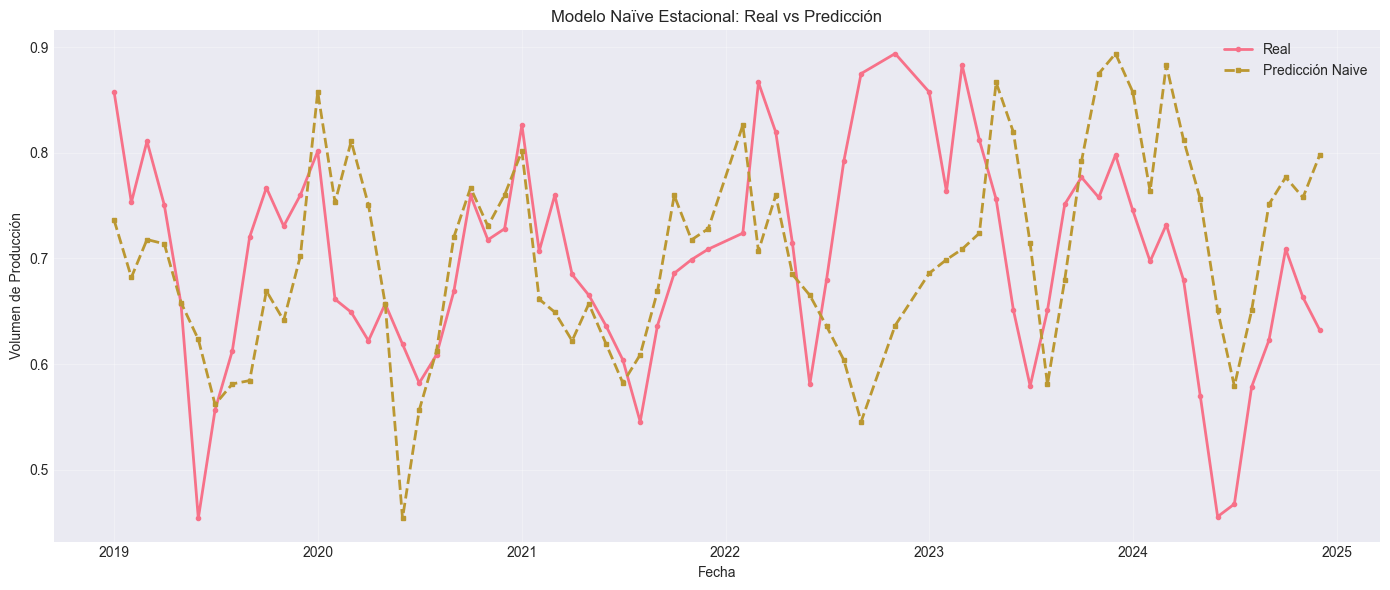

In [13]:
# Visualización: Modelo Naïve Estacional
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(y_test.index, y_test.values, label='Real', linewidth=2, marker='o', markersize=3)
ax.plot(y_test.index, y_naive, label='Predicción Naive', linewidth=2, linestyle='--', marker='s', markersize=3)
ax.set_xlabel('Fecha')
ax.set_ylabel('Volumen de Producción')
ax.set_title('Modelo Naïve Estacional: Real vs Predicción')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### <a class="anchor" id="5_2">5.2 ARIMA</a>

**Descripción:** El modelo **ARIMA (AutoRegressive Integrated Moving Average)** es un enfoque estadístico clásico para series de tiempo univariadas que modela la dependencia temporal a través de tres componentes: autoregresivo (AR), diferenciación (I) y promedio móvil (MA).

ARIMA es especialmente útil cuando la serie presenta patrones autoregresivos y puede volverse estacionaria mediante diferenciación. En este contexto, el modelo utiliza exclusivamente la variable objetivo histórica (`y_train`) para capturar dinámicas internas de la serie sin incorporar variables exógenas.

**Justificación de uso:** Permite establecer un punto de comparación estadístico formal frente al baseline ingenuo y evaluar si la estructura autoregresiva de la serie es suficiente para generar predicciones competitivas.

In [24]:
X.head(10)

,Anio,Sembrada,Cosechada,Rendimiento,Mes_Sin,Mes_Cos
Fecha,,,,,,
1996-01-01,0.0,0.170385,0.093448,0.828413,0.750000,0.933013
1996-02-01,0.0,0.170385,0.093448,0.828413,0.933013,0.750000
1996-03-01,0.0,0.170385,0.093448,0.828413,1.000000,0.500000
1996-04-01,0.0,0.170385,0.093448,0.828413,0.933013,0.250000
1996-05-01,0.0,0.170385,0.093448,0.828413,0.750000,0.066987
1996-06-01,0.0,0.170385,0.093448,0.828413,0.500000,0.000000
1996-07-01,0.0,0.170385,0.093448,0.828413,0.250000,0.066987
1996-08-01,0.0,0.170385,0.093448,0.828413,0.066987,0.250000
1996-09-01,0.0,0.170385,0.093448,0.828413,0.000000,0.500000


#### <a class="anchor" id="5_3">5.3 SARIMAX</a>

**Descripción:** El modelo **SARIMAX (Seasonal ARIMA with eXogenous variables)** extiende ARIMA al incorporar componentes estacionales explícitos y la posibilidad de incluir variables exógenas.

En series mensuales con estacionalidad anual, el componente estacional permite modelar dependencias con rezagos de 12 períodos, mientras que las variables explicativas (`X_train`) pueden capturar efectos estructurales adicionales.

**Justificación de uso:** Permite modelar simultáneamente:

- Dependencias temporales internas.
- Estacionalidad anual.
- Influencia de variables externas.

Representa una evolución natural sobre ARIMA en presencia de patrones estacionales claros.

In [14]:
# TODO: Implementar Modelo 2
print("Modelo 2: Por implementar")

Modelo 2: Por implementar


#### <a class="anchor" id="5_4">5.4 SVR</a>

**Descripción:** El modelo **Support Vector Regression (SVR)** es una extensión de las Máquinas de Vectores de Soporte al problema de regresión. Su objetivo es encontrar una función que minimice el error dentro de un margen tolerado, manteniendo simultáneamente la máxima generalización.

Mediante el uso de kernels (lineal, polinomial o RBF), SVR puede capturar relaciones no lineales entre las variables explicativas y la variable objetivo.

**Justificación de uso:** Permite evaluar si patrones no lineales presentes en las variables explicativas mejoran la capacidad predictiva respecto a modelos puramente autoregresivos.

In [15]:
# TODO: Implementar Modelo 3
print("Modelo 3: Por implementar")

Modelo 3: Por implementar


#### <a class="anchor" id="5_5">5.5 GPR</a>

**Descripción:** La **Gaussian Process Regression (GPR)** es un enfoque probabilístico no paramétrico que modela la serie como una distribución sobre funciones. A través de una función de covarianza (kernel), GPR captura la estructura de dependencia entre observaciones y genera predicciones junto con estimaciones explícitas de incertidumbre.

**Justificación de uso:** Este modelo permite no solo obtener predicciones puntuales, sino también intervalos de confianza, lo cual es especialmente relevante en escenarios productivos donde la incertidumbre es un factor crítico para la toma de decisiones.

In [16]:
# TODO: Implementar Modelo 4
print("Modelo 4: Por implementar")

Modelo 4: Por implementar


#### <a class="anchor" id="5_6">5.6 MLP</a>

**Descripción:** El **Multi-Layer Perceptron (MLP)** es una red neuronal artificial de tipo feedforward compuesta por capas ocultas y funciones de activación no lineales. A través del aprendizaje por retropropagación, el modelo ajusta pesos internos para aproximar relaciones complejas entre entradas y salida.

**Justificación de uso:** Permite capturar interacciones no lineales y combinaciones complejas entre variables explicativas, evaluando si una arquitectura neuronal tradicional supera a métodos estadísticos clásicos en capacidad predictiva.

In [17]:
# TODO: Implementar Modelo 5
print("Modelo 5: Por implementar")

Modelo 5: Por implementar


#### <a class="anchor" id="5_7">5.7 LSTM</a>

**Descripción:** Las **Long Short-Term Memory Networks (LSTM)** son un tipo de red neuronal recurrente diseñada específicamente para modelar dependencias temporales de largo plazo. A diferencia de redes feedforward, las LSTM incorporan celdas de memoria y mecanismos de compuertas que permiten retener o descartar información relevante a lo largo del tiempo.

**Justificación de uso:** Dado que la producción agrícola puede depender de patrones históricos prolongados y efectos acumulativos, LSTM permite capturar dinámicas temporales complejas que podrían no ser modeladas adecuadamente por enfoques tradicionales.

In [18]:
# TODO: Implementar Modelo 6
print("Modelo 6: Por implementar")

Modelo 6: Por implementar


#### <a class="anchor" id="5_8">KNN</a>

**`NOTA`**: Esta sección se agrega como un modelo extraoficial. Ya que KNN hace predicciones promediando vecinos cercanos en el espacio de características, en series de tiempo estructuradas como regresión esto puede funcionar bien en algunos escenarios, y es un modelo sencillo para servir como benchmark adicional.

**Descripción:** El modelo **K-Nearest Neighbors (KNN) Regressor** es un método no paramétrico basado en instancias que realiza predicciones a partir del promedio de los valores observados en los k vecinos más cercanos en el espacio de características.

**Justificación de uso:** Permite evaluar si la similitud estructural entre observaciones históricas puede ser explotada directamente sin asumir una forma funcional específica, actuando como un modelo flexible y de baja complejidad paramétrica.

In [19]:
# TODO: Implementar Modelo Extra
print("Modelo Extra: Por implementar")

Modelo Extra: Por implementar


### <a class="anchor" id="comparacion">6. Comparación global de modelos</a>

XXX

In [20]:
# Pendiente: Crear DataFrame con resultados de todos los modelos para hacer comparaciones

#### 6.1 Visualización comparativa

XXX

In [21]:
# Pendiente: gráfica de predicciones de todos los modelos

In [22]:
# Pendiente: gráfica comparativa de métricas

### <a class="anchor" id="seleccion">7. Selección de mejores modelos y ajuste de hiperparámetros</a>

XXX

In [23]:
# Pendiente: Seleccionar los dos mejores modelos según RMSE (¿o cuál métrica usar?)

#### 7.1 Ajuste del primer mejor modelo

XXX

In [24]:
# Pendiente: Implementar ajuste de hiperparámetros del primer modelo

#### 7.2 Ajuste del segundo mejor modelo

XXX

In [25]:
# Pendiente: Implementar ajuste de hiperparámetros del segundo modelo

### <a class="anchor" id="analisis">8. Análisis crítico</a>

XXX

#### 8.1 ¿El modelo más complejo fue el mejor?

[Responder en base a los resultados]

#### 8.2 ¿Hubo sobreajuste (overfitting)?

[Responder en base a comparación entre métricas de entrenamiento y prueba]

#### 8.3 ¿Los modelos temporales superaron a los no temporales?

[Responder en base a arquitectura de modelos y resultados]

#### 8.4 ¿La incertidumbre aportó valor?

[Responder en base a la inclusión de intervalos de confianza o métodos probabilísticos]

### <a class="anchor" id="conclusiones">Conclusiones</a>

#### Modelo recomendado

[Especificar cuál de los modelos se recomienda y por qué]


#### Justificación

[Explicar los criterios de selección: desempeño, interpretabilidad, estabilidad, etc.]

#### Limitaciones o Problemas

[Describir limitaciones de los modelos y del análisis]

### <a class="anchor" id="ref">Referencias</a>

xxx